## RUN IF IMPORTING IS NEEDED

In [3]:
!pip install dataprep
!pip install gradio
!pip install h5py
!pip install typing-extensions
!pip install wheel

  Using cached pydantic-2.7.1-py3-none-any.whl (409 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.15
    Uninstalling pydantic-1.10.15:
      Successfully uninstalled pydantic-1.10.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataprep 0.4.5 requires pydantic<2.0,>=1.6, but you have pydantic 2.7.1 which is incompatible.
spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.


In [106]:
# Import all libraries needed
import pandas as pd
import numpy as np
from dataprep.eda import create_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.metrics as metrics
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

## Loading and preprocessing data
We will be using the kaggle data found here:

https://www.kaggle.com/datasets/princeiornongu/merged-cc


We will be loading the data from a csv file into a dataframe and cleaning the data.

Steps:
- Check for empty values and duplicates
- Drop duplicates and empty values
- Create a dataprep report to see a correlation graph of our data and any insights
- Clean data and print a graph that shows what our data looks like for the temperature changes to see if we can make any observations

In [6]:
# Reads the csv
climate_change_df = pd.read_csv("CC.csv")

# create_report(climate_change_df).show()

# Drop duplicates and drop columns that only have a single value
climate_change_df.dropna(inplace=True)
climate_change_df.drop_duplicates(inplace=True)

In [ ]:
#Print .head()
climate_change_df.head()

Cleaning the data:
- Only focus on temperature changes in 5 countries from 1961-2022 for the graph

In [7]:
countries_to_keep = ["United States", "United Kingdom", "France", "Canada", "Japan"]
columns_years = [str(year) for year in range(1961, 2023)]
columns_selected = ['Country'] + columns_years

# Filter the DataFrame for the selected countries and years
cleaned_df = climate_change_df[climate_change_df['Country'].isin(countries_to_keep)][columns_selected]

# Convert Celsius to Fahrenheit and round everything to two decimal points
for year in columns_years:
    cleaned_df[year] = cleaned_df[year].apply(lambda x: round(x * 1.8 + 32, 2))

# Ensure 'Country' is set as the index before plotting
cleaned_df.set_index('Country', inplace=True)

print(cleaned_df.dtypes)
cleaned_df

1961    float64
1962    float64
1963    float64
1964    float64
1965    float64
         ...   
2018    float64
2019    float64
2020    float64
2021    float64
2022    float64
Length: 62, dtype: object


,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Country,,,,,,,,,,,,,,,,,,,,,
Canada,32.10,31.79,32.60,31.46,30.44,31.73,31.19,32.86,31.99,32.77,...,34.13,32.52,34.22,36.27,34.66,32.86,34.36,34.03,36.53,34.28
France,33.49,31.46,30.28,32.05,30.88,32.76,32.89,31.87,32.04,31.83,...,33.29,35.69,34.90,35.23,35.23,35.71,35.64,36.59,34.41,37.27
Japan,33.20,32.23,31.90,32.48,31.07,32.03,32.06,31.10,31.91,31.31,...,33.13,33.01,33.50,34.38,33.43,33.67,34.29,34.59,34.29,34.40
United Kingdom,32.88,30.68,30.44,32.05,30.96,31.75,32.40,31.87,31.62,31.86,...,32.66,35.09,33.11,34.09,34.56,33.80,34.22,34.47,33.67,35.44
United States,32.01,31.95,32.75,31.49,31.35,31.61,32.14,31.87,31.52,31.95,...,33.11,32.90,34.76,36.00,34.58,34.30,33.86,34.38,34.06,34.19


Trends of the temperature changes from 1961-2022

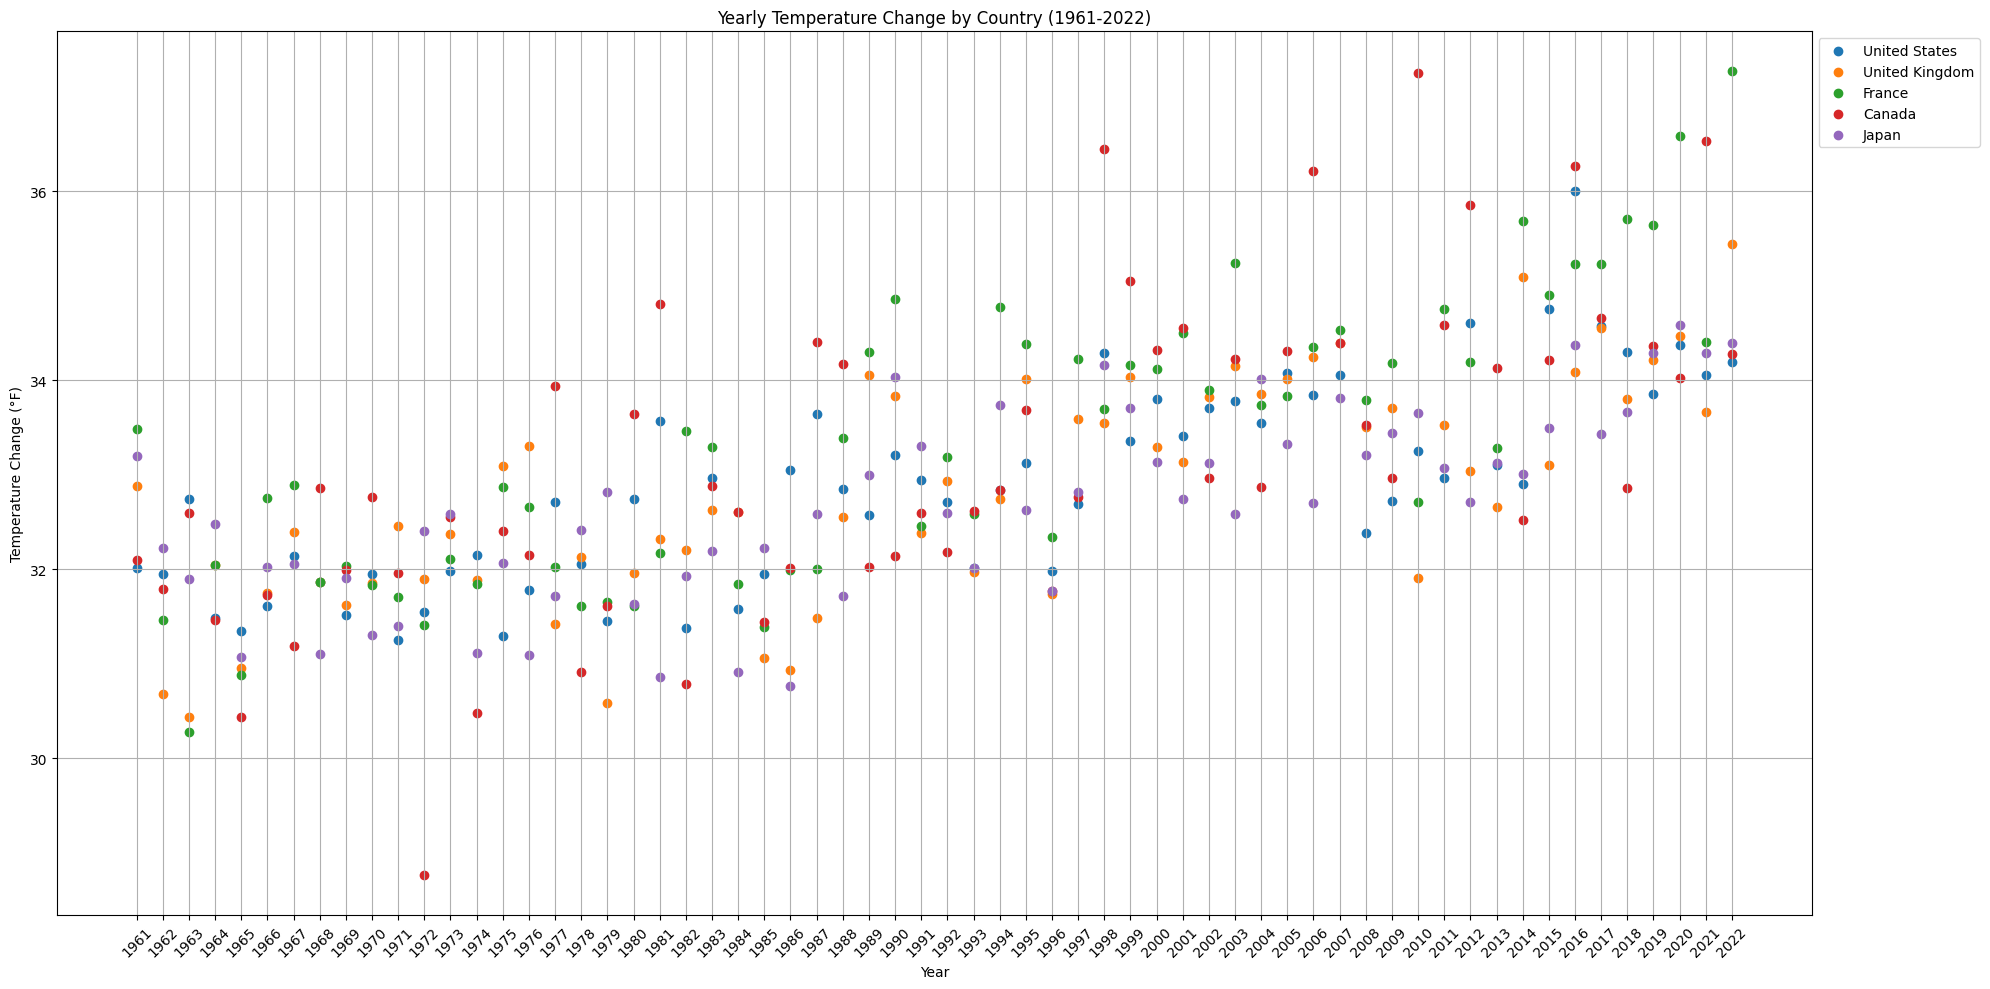

In [8]:
# Create scatter plots for each country over the selected years
plt.figure(figsize=(20, 10))
for country in countries_to_keep:
    if country in cleaned_df.index:
        plt.scatter(columns_years, cleaned_df.loc[country], label=country)

plt.title('Yearly Temperature Change by Country (1961-2022)')
plt.xlabel('Year')
plt.ylabel('Temperature Change (°F)')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


## Feature Engineering

Features used are: Country, Sub-region, income group, density, surface temperature change for each year (1961 - 2022)

For our label, we will create our own column of the average of the surface temperature through 1961 to 2022 for each country and add it into the dataset, as we want to predict how various factors can affect the average surface temperature change and see it will either be a high predicted change, low predicted change, or neither.

In [ ]:
# Go through each country and stack them, figuring out the average surface temp change. put into list averageSTC

average_STC = []

def categorize_change(country):
  temp = []
  average_calc = 0
  country_index = np.where(climate_change_df['Country'] == country)

  for year in columns_years:
    temp.append(climate_change_df[year].iloc[country_index])

  temp = sum(temp) / len(temp)
  return temp

for country in climate_change_df['Country']:
    temp = categorize_change(country)
    average_STC.append(temp)

In [80]:
# Calculate thresholds for high, medium, and low temperature changes using the filtered data
low_threshold = np.percentile(average_STC, 25)
high_threshold = np.percentile(average_STC, 75)

#Check quartile
print(low_threshold, high_threshold)

cleaned_average_STC = []

#Change values to be based on the thresholds. 0 - High, 1 - Medium, 2 - Low
for i in average_STC:
    i_temp = i.item()
    if i_temp > high_threshold:
        cleaned_average_STC.append(0)
    elif i_temp < low_threshold:
        cleaned_average_STC.append(2)
    else:
        cleaned_average_STC.append(1)

#Make into a dataframe and combine with original dataframe
df = pd.DataFrame(cleaned_average_STC, columns=(['Average STC']))
df = pd.concat([climate_change_df, df], axis=1)

#Rename area and density to remove the km^2
df.rename(columns={'Density (KM²)': 'Density', 'Area (KM²)': 'Area'}, inplace=True)

0.4088254865458241 0.6128711841532108


In [81]:
#Get head of the dataframe again after concat
df.head()

,Country,ISO3,Indicator,Unit,Source,1961,1962,1963,1964,1965,...,2018,2019,2020,2021,2022,Sub-Region,Income Group,Area,Density,Average STC
0,Albania,ALB,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,0.627,0.326,0.075,-0.166,-0.388,...,2.028,1.675,1.498,1.536,1.518,Europe & Central Asia,Upper middle income,28748.0,103,1
1,Algeria,DZA,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,0.164,0.114,0.077,0.250,-0.100,...,1.210,1.115,1.926,2.330,1.688,Middle East & North Africa,Lower middle income,2381741.0,19,0
2,American Samoa,ASM,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,0.079,-0.042,0.169,-0.140,-0.562,...,1.189,1.539,1.430,1.268,1.256,East Asia & Pacific,High income,199.0,220,1
3,Angola,AGO,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,0.041,-0.152,-0.190,-0.229,-0.196,...,1.395,1.752,1.162,1.553,1.212,Sub-Saharan Africa,Lower middle income,1246700.0,29,1
4,Antigua and Barbuda,ATG,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,0.090,0.031,0.288,0.214,-0.385,...,0.627,0.797,1.131,0.862,0.770,Latin America & Caribbean,High income,442.0,214,2


In [83]:
#Create feature dataframe & label dataframe
features_df = df[['1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', "Country", "Sub-Region","Density"]]
features_df.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2016,2017,2018,2019,2020,2021,2022,Country,Sub-Region,Density
0,0.627,0.326,0.075,-0.166,-0.388,0.559,-0.074,0.081,-0.013,-0.106,...,1.464,1.121,2.028,1.675,1.498,1.536,1.518,Albania,Europe & Central Asia,103
1,0.164,0.114,0.077,0.250,-0.100,0.433,-0.026,-0.067,0.291,0.116,...,1.757,1.512,1.210,1.115,1.926,2.330,1.688,Algeria,Middle East & North Africa,19
2,0.079,-0.042,0.169,-0.140,-0.562,0.181,-0.368,-0.187,0.132,-0.047,...,1.539,1.435,1.189,1.539,1.430,1.268,1.256,American Samoa,East Asia & Pacific,220
3,0.041,-0.152,-0.190,-0.229,-0.196,0.175,-0.081,-0.193,0.188,0.248,...,1.609,0.870,1.395,1.752,1.162,1.553,1.212,Angola,Sub-Saharan Africa,29
4,0.090,0.031,0.288,0.214,-0.385,0.097,-0.192,-0.225,0.271,0.109,...,1.097,0.958,0.627,0.797,1.131,0.862,0.770,Antigua and Barbuda,Latin America & Caribbean,214


In [84]:
labels_df = df[['Average STC']]
labels_df.head()

,Average STC
0,1
1,0
2,1
3,1
4,2


## ONE HOT ENCODING
As the Country, Sub-Region, and Density values are categorical nominal, we will be conducting one hot encoding on them so that they are usable to train our dataset.  

For our Scaler, we will be using Standard Scaler as the data we are using has a Normal distribution.

In [95]:
#Make a list of all 3 categorical nominal DFs
country_list = features_df["Country"].to_list()
region_list = features_df["Sub-Region"].to_list()
density_list = features_df["Density"].to_list()

#Make 2D lists of all values
result_array = [[item1] for item1 in country_list]
result_array2 = [[item2] for item2 in region_list]
result_array3 = [[item3] for item3 in density_list]

encoder1 = OneHotEncoder()
encoder2 = OneHotEncoder()
encoder3 = OneHotEncoder()

#Fit and transform each array
encoder1.fit(result_array)
transformed = encoder1.transform(result_array)
transformed = transformed.toarray()

encoder2.fit(result_array2)
transformed2 = encoder2.transform(result_array2)
transformed2 = transformed2.toarray()

encoder3.fit(result_array3)
transformed3 = encoder3.transform(result_array3)
transformed3 = transformed3.toarray()

#Merge into features_df by transforming the OHEs into a DF and resetting index

trans_df = pd.DataFrame(transformed)
trans_df2 = pd.DataFrame(transformed2)
trans_df3 = pd.DataFrame(transformed3)

features_df.reset_index(drop=True, inplace=True)
trans_df.reset_index(drop=True, inplace=True)
trans_df2.reset_index(drop=True, inplace=True)
trans_df3.reset_index(drop=True, inplace=True)

trans_features_df = pd.concat([features_df,trans_df, trans_df2, trans_df3], axis=1)
print(trans_features_df.shape)

#Drop the columsn we don't need
trans_features_df = trans_features_df.drop(columns=["Country", "Sub-Region", "Density"], axis=1)

#Scale numerical values (years) with StandardScaler
scaler = StandardScaler()
trans_features_df[columns_years] = scaler.fit_transform(trans_features_df[columns_years])
trans_features_df.head()

(141, 321)


,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,98,99,100,101,102,103,104,105,106,107
0,1.120005,1.037186,0.259265,-0.300312,-0.550827,1.187216,0.129292,0.992008,-0.585607,-0.580495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.016892,0.422508,0.264782,1.123549,0.520950,0.868994,0.276711,0.444015,0.463263,0.122101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.225609,-0.029801,0.518538,-0.211320,-1.198358,0.232549,-0.773649,-0.000304,-0.085324,-0.393769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.318918,-0.348738,-0.471663,-0.515944,0.163691,0.217395,0.107794,-0.022519,0.107889,0.539861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.198599,0.181856,0.846766,1.000330,-0.539662,0.020401,-0.233113,-0.141004,0.394258,0.099947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 ## Data Splitting


We will be splitting our data into 90 traintest, 10 test to see how accurate various models are.

We will be using SVC linear, SVC rbf, RandomForestClassifier as they are classifiers that assist us best in our current situation (Supervised classification).

 - Figure out if data is underfitting or overfitting through K-fold validation & cross val score
        - We will be doing 5 folds
 - Ablation studies
 - Classification Report


In [116]:
#Make data into numpy array
features = trans_features_df.to_numpy()
labels = labels_df.to_numpy()

#Make test and train data & do kfold evaluation
_x, x_test, _y, y_test = train_test_split(features, labels, test_size=0.10, random_state=42)

# set k = 5
k = 5

kfold_spliiter = KFold(n_splits=k)

folds_data = [] # this is an inefficient way but still do it

fold = 1
for train_index, validation_index in kfold_spliiter.split(_x):
    x_train , x_valid = _x[train_index,:],_x[validation_index,:]
    y_train , y_valid = _y[train_index,:] , _y[validation_index,:]
    print (f"Fold {fold} training data shape = {(x_train.shape,y_train.shape)}")
    print (f"Fold {fold} validation data shape = {(x_valid.shape,y_valid.shape)}")
    fold+=1
    folds_data.append((x_train,y_train,x_valid,y_valid))

Fold 1 training data shape = ((100, 318), (100, 1))
Fold 1 validation data shape = ((26, 318), (26, 1))
Fold 2 training data shape = ((101, 318), (101, 1))
Fold 2 validation data shape = ((25, 318), (25, 1))
Fold 3 training data shape = ((101, 318), (101, 1))
Fold 3 validation data shape = ((25, 318), (25, 1))
Fold 4 training data shape = ((101, 318), (101, 1))
Fold 4 validation data shape = ((25, 318), (25, 1))
Fold 5 training data shape = ((101, 318), (101, 1))
Fold 5 validation data shape = ((25, 318), (25, 1))


In [122]:
#Linear regression model training
svm_linear = SVC(kernel="linear")
svm_rbf = SVC(kernel="rbf")
dt = DecisionTreeClassifier()

all_models = {
              "svm_linear":svm_linear,
              "svm_rbf":svm_rbf,
              "decision_tree":dt,
              }

print (f"We are working with classifiers {all_models.keys()}")

We are working with classifiers dict_keys(['svm_linear', 'svm_rbf', 'decision_tree'])


In [123]:
best_validation_accuracy = 0
best_model_name = ""
best_model = None

# Iterate over all models
for model_name in all_models.keys():

    print (f"Evaluating {model_name} ...")
    model = all_models[model_name]

    # Let's store training and validation accuracies for all folds
    train_acc_for_all_folds = []
    valid_acc_for_all_folds = []

    #Iterate over all folds
    for i, fold in enumerate(folds_data):
        x_train, y_train, x_valid, y_valid = fold

        # Train the model
        _ = model.fit(x_train,y_train.flatten())

        # Evluate model on training data
        y_pred_train = model.predict(x_train)

        # Evaluate the model on validation data
        y_pred_valid = model.predict(x_valid)

        # Compute training accuracy
        train_acc = accuracy_score(y_pred_train , y_train)

        # Store training accuracy for each folds
        train_acc_for_all_folds.append(train_acc)

        # Compute validation accuracy
        valid_acc = accuracy_score(y_pred_valid , y_valid.flatten())

        # Store validation accuracy for each folds
        valid_acc_for_all_folds.append(valid_acc)

    #average training accuracy across k folds
    avg_training_acc = sum(train_acc_for_all_folds)/k

    print (f"Average training accuracy for model {model_name} = {avg_training_acc}")

    #average validation accuracy across k folds
    avg_validation_acc = sum(valid_acc_for_all_folds)/k

    print (f"Average validation accuracy for model {model_name} = {avg_validation_acc}")

    # Select best model based on average validation accuracy
    if avg_validation_acc > best_validation_accuracy:
        best_validation_accuracy = avg_validation_acc
        best_model_name = model_name
        best_model = model
    print (f"-----------------------------------")

print (f"Best model for the task is {best_model_name} which offers the validation accuracy of {best_validation_accuracy}")

Evaluating svm_linear ...
Average training accuracy for model svm_linear = 1.0
Average validation accuracy for model svm_linear = 0.8963076923076922
-----------------------------------
Evaluating svm_rbf ...
Average training accuracy for model svm_rbf = 0.9880990099009901
Average validation accuracy for model svm_rbf = 0.8252307692307692
-----------------------------------
Evaluating decision_tree ...
Average training accuracy for model decision_tree = 1.0
Average validation accuracy for model decision_tree = 0.762153846153846
-----------------------------------
Best model for the task is svm_linear which offers the validation accuracy of 0.8963076923076922


The best model was SVM_Linear with a score of 0.89, which is a pretty reliable high accuracy score for this dataset.

In [ ]:
best_validation_accuracy = 0
best_model_name = ""
best_model = None

# Iterate over all models
for model_name in all_models.keys():

    print (f"Evaluating {model_name} ...")
    model = all_models[model_name]

    # Let's store training and validation accuracies for all folds
    train_acc_for_all_folds = []
    valid_acc_for_all_folds = []

    #Iterate over all folds
    for i, fold in enumerate(folds_data):
        x_train, y_train, x_valid, y_valid = fold

        # Train the model
        _ = model.fit(x_train,y_train.flatten())

        # Evluate model on training data
        y_pred_train = model.predict(x_train)

        # Evaluate the model on validation data
        y_pred_valid = model.predict(x_valid)

        # Compute training accuracy
        train_acc = accuracy_score(y_pred_train , y_train)

        # Store training accuracy for each folds
        train_acc_for_all_folds.append(train_acc)

        # Compute validation accuracy
        valid_acc = accuracy_score(y_pred_valid , y_valid.flatten())

        # Store validation accuracy for each folds
        valid_acc_for_all_folds.append(valid_acc)

    #average training accuracy across k folds
    avg_training_acc = sum(train_acc_for_all_folds)/k

    print (f"Average training accuracy for model {model_name} = {avg_training_acc}")

    #average validation accuracy across k folds
    avg_validation_acc = sum(valid_acc_for_all_folds)/k

    print (f"Average validation accuracy for model {model_name} = {avg_validation_acc}")

    # Select best model based on average validation accuracy
    if avg_validation_acc > best_validation_accuracy:
        best_validation_accuracy = avg_validation_acc
        best_model_name = model_name
        best_model = model
    print (f"-----------------------------------")

print (f"Best model for the task is {best_model_name} which offers the validation accuracy of {best_validation_accuracy}")

In [128]:
# Storing
import pickle

file_to_write = open("best_model.saved","wb")
pickle.dump(best_model,file_to_write)
file_to_write.close()

# Storing test data
file_to_write = open("test_data.dat","wb")
pickle.dump([x_test,y_test],file_to_write)
file_to_write.close()

# Opening test data
model_file = open("best_model.saved","rb")
model = pickle.load(model_file)
model_file.close()

test_data_file = open("test_data.dat","rb")
x_test,y_test = pickle.load(test_data_file)
test_data_file.close()

# Test accuracy on our test dataset
y_pred_test = model.predict(x_test)

# Compute accuracy on test data
accuracy = accuracy_score(y_pred_test, y_test.flatten())

# Print accuracy on the test data

print (f"Accuracy on test data {accuracy}")

Accuracy on test data 1.0


## Ablation Test

In [130]:
best_model = RandomForestClassifier()

feature_names = features_df.columns

# Let's maintain an accuracy dictionary
# We first compute the accuracy without ablation using K-fold cross validation

cv_scores = cross_val_score(best_model,_x,_y.flatten(), cv=k, n_jobs=4)
average_cv_score_with_all_features = cv_scores.mean()

accuracy_drop_log = {"No ablation":0}

for i in range(len(feature_names)):
    # we are going to drop one feature at a time
    feature_name = feature_names[i]
    print (f"Removing feature {feature_name}")

    # Remmeber? We have the train + valid data in the above section?
    # We just remove the feature by not selecting the column from the index i

    x_ablated = np.delete(_x,i,axis=1) # axis = 1 means columns

    cv_scores = cross_val_score(best_model,x_ablated,_y.flatten(), cv=k, n_jobs=4)
    average_cv_score = cv_scores.mean()
    print (f"Mean cross validation accuracy = {average_cv_score}")
    accuracy_drop_log[feature_name] = average_cv_score_with_all_features-average_cv_score

Removing feature 1961
Mean cross validation accuracy = 0.8578461538461539
Removing feature 1962
Mean cross validation accuracy = 0.8818461538461537
Removing feature 1963
Mean cross validation accuracy = 0.8498461538461539
Removing feature 1964
Mean cross validation accuracy = 0.8578461538461537
Removing feature 1965
Mean cross validation accuracy = 0.834153846153846
Removing feature 1966
Mean cross validation accuracy = 0.8495384615384616
Removing feature 1967
Mean cross validation accuracy = 0.8498461538461539
Removing feature 1968
Mean cross validation accuracy = 0.8495384615384616
Removing feature 1969
Mean cross validation accuracy = 0.866153846153846
Removing feature 1970
Mean cross validation accuracy = 0.8418461538461539
Removing feature 1971
Mean cross validation accuracy = 0.8575384615384616
Removing feature 1972
Mean cross validation accuracy = 0.850153846153846
Removing feature 1973
Mean cross validation accuracy = 0.850153846153846
Removing feature 1974
Mean cross validatio

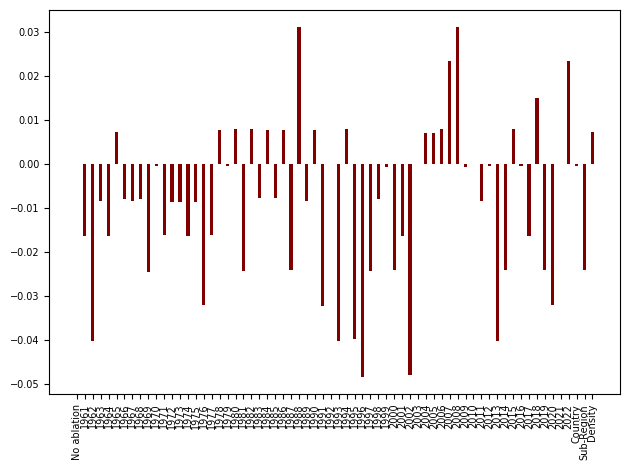

In [141]:
plt.bar(accuracy_drop_log.keys(), accuracy_drop_log.values(), color="maroon", width = 0.4)
plt.rcParams.update({'font.size': 10})
plt.xticks(rotation=90)
plt.tight_layout()

From the Ablation test, we can see that certain values of years, such as the year 1988 has a positive impact on the results, while values such as the Sub-region and years such as 2002, 1996, 2013, and many other years feature values have a negative relation on the accuracy.

Demo using Gradio

In [143]:
import gradio as gr
import joblib

# Load the model and any other necessary files
model = joblib.load('/path/to/my_random_forest_model.pkl')
model_columns = joblib.load('/path/to/model_columns.pkl')

def predict_temperature_change(year, country, density, sub_region, income_group):
    # Create input DataFrame based on the inputs
    input_data = pd.DataFrame({
        'Year': [year],
        'Country': [country],
        'Density': [density],
        'SubRegion': [sub_region],
        'IncomeGroup': [income_group]
    })

    # One-hot encode the input DataFrame
    input_encoded = pd.get_dummies(input_data)

    # Ensure all necessary columns are present, even if they're missing in the input
    for col in model_columns:
        if col not in input_encoded.columns:
            input_encoded[col] = 0

    # Align columns to match the model's training data
    input_encoded = input_encoded.reindex(columns=model_columns, fill_value=0)

    # Predict and return the result
    prediction = model.predict(input_encoded)
    return prediction[0]

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/my_random_forest_model.pkl'

## Old code: folding. Reference later if needed

In [ ]:
'''
  NOT NEEDED: LEAVING JUST IN CASE

  # Calculate thresholds for high, medium, and low temperature changes using the filtered data
  high_threshold = filtered_df[year_columns].stack().quantile(0.75)
  low_threshold = filtered_df[year_columns].stack().quantile(0.25)

  # Function to categorize temperature changes based off which quartile they are in
  def categorize_change(temp):
      if temp > high_threshold:
          return 'High Change'
      elif temp < low_threshold:
          return 'Low Change'
      else:
          return 'Medium Change'

  # Apply the function to each year's data in the filtered DataFrame
  for year in year_columns:
      filtered_df[f'{year}_Category'] = filtered_df[year].apply(categorize_change)

  Leaving it here for now - Kem

  # One-hot encoding for categorical variables
  yearly_categories = pd.get_dummies(filtered_df[[f'{year}_Category' for year in year_columns]], prefix=year_columns)
  density_bins = pd.qcut(filtered_df['Density (KM²)'], 3, labels=["Low Density", "Medium Density", "High Density"])
  density_encoded = pd.get_dummies(density_bins)
  sub_region_encoded = pd.get_dummies(filtered_df['Sub-Region'], prefix='SubRegion')
  income_group_encoded = pd.get_dummies(filtered_df['Income Group'], prefix='IncomeGroup')

  # Combine all encoded data frames into one
  encoded_data = pd.concat([yearly_categories, density_encoded, sub_region_encoded, income_group_encoded], axis=1)
'''